<a href="https://colab.research.google.com/github/Corbibac/DeepLearning/blob/main/CharlesCARRERE_ClementMOUNIER_deep_learning_report_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Report for the Deep Learning Course
This is a template notebook of your report. Please complete your report with your teammate following these instructions:
- **Rename your notebook** in the format `FirstName1FAMILYNAME1_FirstName2FAMILYNAME2_report2.ipynb`. For example, when the team consists of Johann FAOUZI and Ikko YAMANE, the file name should look like `JohannFAOUZI_IkkoYAMANE_report2.ipynb`.
- Answer in English.
- Please submit your notebook on Moodle.
- The submission deadline is 18:00 (UTC+2) of December 15, 2024.


**Remarks**:
- The accuracy of your models is not important for the evaluation, but I expect the performance is at least better than a random guess or a constant predictor.
- I encourage you to explain your problem setups/code/algorithms/archtectures/methods/tools/results with Python comments or Markdown text. You can use figures, plots, or other visualization techniques. The quality of explanations will be great part of the evaluation.
- Needless to say, do not copy solutions from other students.
- If your code is based on any articles, code examples, or web pages, **clearly mention the references and how you used them**.
- Likewise, if you use AI tools, clearly explain how you used them and which parts of your answers were given by the AIs, and make sure that you check and understand those parts yourself.
- If I detect any work copied from anywhere else without acknowledging it, your grade will get a **significant penalty**.

## Question 0
Enter your information below.
- Name of Author 1:CARRERE Charles
- Name of Author 2:MOUNIER Clement
- Email address of Author 1:charles.carrere@eleve.ensai.fr
- Email address of Author 2:clement.mounier@eleve.ensai.fr


## Question 1 (Noun-Verb Classification)

Train two different classifiers for the Noun-Verb dataset [1], which we have seen in the ateliers, and compare their performance.

---
**References**

[1] Ali Elkahky and Kellie Webster and Daniel Andor and Emily Pitler. A Challenge Set and Methods for Noun-Verb Ambiguity, In *Proceedings of EMNLP*, 2018.

## Question 2 (Food Image Classification)

By adapting the LeNet-5 [3], train a simple classifier for a resized version of the [Food-7 dataset](https://huggingface.co/datasets/cv-talks/food-7) dataset, which is a subset of the Food-101 dataset [2].

Execute the following five code cells to load the dataset.

---
**References**

[2] Bossard, Lukas; Guillaumin, Matthieu; Van Gool, Luc. Food-101 -- Mining Discriminative Components with Random Forests,
_European Conference on Computer Vision_, 2014.
URL: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/.


[3] Lecun, Yann; Bottou, Léon; Bengio, Yoshua; Haffner, Patrick. "Gradient-based learning applied to document recognition" (PDF). _Proceedings of the IEEE_. 86 (11): 2278–2324, 1998.

In [1]:
!pip install datasets[vision]
!pip install gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import os
import gdown
import zipfile
from datasets import load_from_disk


def download_food7(path='data/food'):
    filename = 'food7_34x34.zip'
    gdriveid = '1eZFfl8MUSN_WeovPkxR0_R7DS7TzQrxk'

    if not os.path.exists(path):
        os.makedirs(path)

    filepath = os.path.join(path, filename)
    if not os.path.isfile(filepath):
        gdown.download(id=gdriveid, output=filepath, quiet=False)


def load_food7(path='data/food'):
    filename = 'food7_34x34.zip'
    filepath = os.path.join(path, filename)
    with zipfile.ZipFile(filepath, 'r') as f:
        f.extractall(path)

    ds = load_from_disk(path)
    label_names = ds.features['label'].names
    class2name = {i: label_names[i] for i in range(len(label_names))}

    return ds, class2name


download_food7()
ds_food7, class2name = load_food7()

Downloading...
From (original): https://drive.google.com/uc?id=1eZFfl8MUSN_WeovPkxR0_R7DS7TzQrxk
From (redirected): https://drive.google.com/uc?id=1eZFfl8MUSN_WeovPkxR0_R7DS7TzQrxk&confirm=t&uuid=8cde799a-38dd-4cea-b70d-f44c18c7e16e
To: /content/data/food/food7_34x34.zip
100%|██████████| 33.1M/33.1M [00:01<00:00, 28.9MB/s]


In [3]:
# Split the dataset to train (size 6000) and test (size 1000) splits.

from torch.utils.data import random_split

train_size = 6000
test_size = 1000

ds_food7_split = ds_food7.train_test_split(
    train_size=train_size,
    test_size=test_size,
    stratify_by_column='label'
)

In [4]:
# Prepare dataloaders.

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import v2 as tvtf

def collate_fn1(minibatch):
    """ Transform each minibatch.
    """
    images = []
    labels = []
    for example in minibatch:
        images.append(example["image"])
        labels.append(example["label"])

    return torch.tensor(images), torch.tensor(labels)

dataloader_train = DataLoader(ds_food7_split['train'], collate_fn=collate_fn1, batch_size=32)
dataloader_test = DataLoader(ds_food7_split['test'], collate_fn=collate_fn1, batch_size=128)

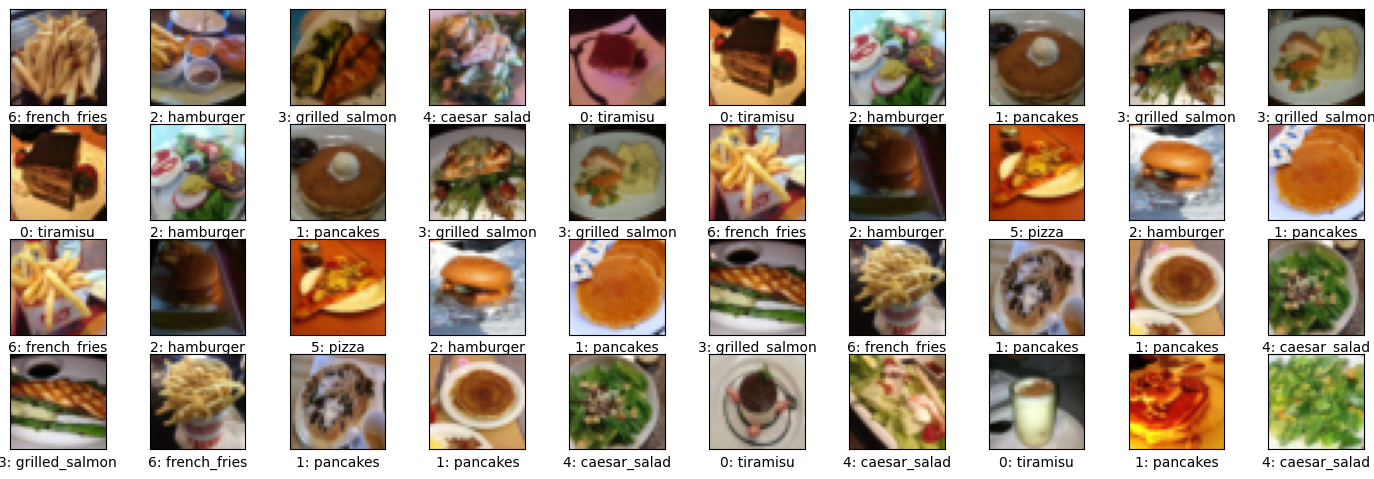

In [5]:
# Show example images.

import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def show_example_images(dataset):
    nrow = 4
    ncol = 10
    fig, ax = plt.subplots(nrow, ncol, figsize=(10, 4))

    X, y = next(iter(DataLoader(
            ds_food7,
            collate_fn=collate_fn1,
            batch_size=nrow * ncol,
            shuffle=True)))

    for i in range(nrow):
        for j in range(ncol):
            # img = minibatch['image'][5*i + j]
            # label = minibatch['label'][5*i + j]
            img = X[5*i + j]
            label = y[5*i + j]
            ax[i][j].imshow(np.transpose(img, [1, 2, 0]))
            ax[i][j].set_xticks([])
            ax[i][j].set_yticks([])
            ax[i][j].set_xlabel(f'{label.item()}: {class2name[label.item()]}')

    fig.subplots_adjust(bottom=0.1, right=1.5, top=1.2)

show_example_images(dataset=ds_food7)

### How to use the Food-7 dataset

After executing the previous five cells, you will get the following objects.

- `dataloader_train`: `torch.data.util.Dataloader` object holding the training split of the dataset. The size is 6000.

- `dataloader_test`: `torch.data.util.Dataloader` object holding the test split of the dataset. The size is 1000.

- `class2name`: Python dictionary to map a numerically represented class to its name. For example, `class2name[0] == 'tiramisu'`.

- `ds_food7`: the Hugging Face `datasets.Dataset` object storing the whole dataset.

Each image has 3 channels and is of size $34 \times 34$. There are 7 classes. See the last code cell to learn how to use the dataloader.

# Q2 ANSWER


## UsualLeNet5, and random forest to compare

main sources: https://en.wikipedia.org/wiki/LeNet , Solution 2-1 from the in class practice

For this first LeNet5 implementation, we follow the historical and first code (almost). We make it slightly more modern with ReLu activation function instead of sigmoid ones. Also, the LeNet-5 model was meant to take 28x28 pictures in different sahdes of grey. We have to adapt the coded to make it work with 34x34 RGB images.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet5Food7(nn.Module):
    def __init__(self, num_classes=7):
        super(LeNet5Food7, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # Update to match flattened size
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))       # -> (batch_size, 6, 34, 34)
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # -> (batch_size, 6, 17, 17)
        x = F.relu(self.conv2(x))       # -> (batch_size, 16, 13, 13)
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # -> (batch_size, 16, 6, 6)
        x = x.view(-1, 16 * 6 * 6)     # Flatten -> (batch_size, 16*6*6)
        x = F.relu(self.fc1(x))        # -> (batch_size, 120)
        x = F.relu(self.fc2(x))        # -> (batch_size, 84)
        x = self.fc3(x)                # -> (batch_size, num_classes)
        return x



In [7]:
def train_model(model, dataloader, optimizer, criterion, num_epochs=10, device='cuda'):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in dataloader:
            images, labels = images.to(device, dtype=torch.float32), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader):.4f}, Accuracy: {100 * correct/total:.2f}%")


In [8]:
def evaluate_model(model, dataloader, criterion, device='cuda'):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device, dtype=torch.float32), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    print(f"Test Loss: {running_loss/len(dataloader):.4f}, Test Accuracy: {100 * correct/total:.2f}%")


In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = LeNet5Food7(num_classes=7)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_model(model, dataloader_train, optimizer, criterion, num_epochs=10, device=device)

# Evaluate the model
evaluate_model(model, dataloader_test, criterion, device=device)


Epoch 1/10, Loss: 1.9019, Accuracy: 19.78%
Epoch 2/10, Loss: 1.7635, Accuracy: 30.77%
Epoch 3/10, Loss: 1.6179, Accuracy: 38.80%
Epoch 4/10, Loss: 1.5398, Accuracy: 41.78%
Epoch 5/10, Loss: 1.4880, Accuracy: 44.68%
Epoch 6/10, Loss: 1.4403, Accuracy: 46.55%
Epoch 7/10, Loss: 1.3981, Accuracy: 48.15%
Epoch 8/10, Loss: 1.3598, Accuracy: 49.80%
Epoch 9/10, Loss: 1.3191, Accuracy: 51.95%
Epoch 10/10, Loss: 1.2796, Accuracy: 53.45%
Test Loss: 1.4627, Test Accuracy: 45.70%


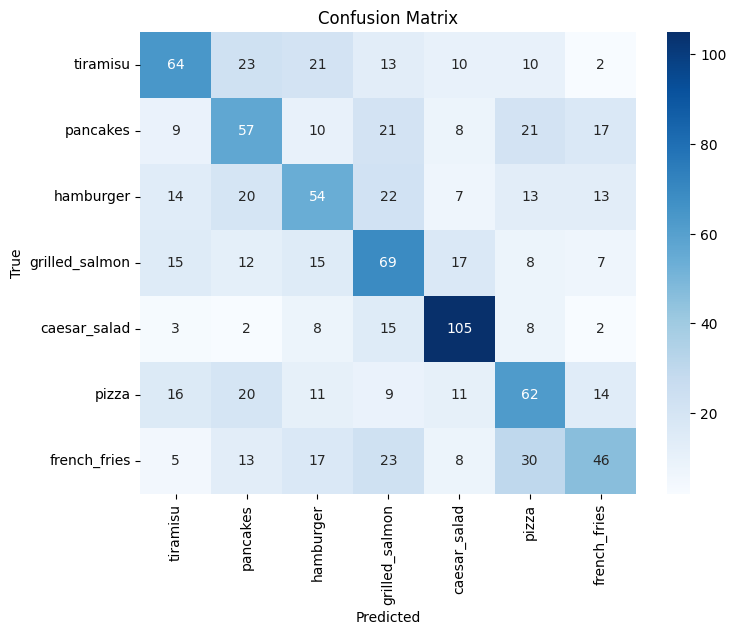

                precision    recall  f1-score   support

      tiramisu       0.51      0.45      0.48       143
      pancakes       0.39      0.40      0.39       143
     hamburger       0.40      0.38      0.39       143
grilled_salmon       0.40      0.48      0.44       143
  caesar_salad       0.63      0.73      0.68       143
         pizza       0.41      0.43      0.42       143
  french_fries       0.46      0.32      0.38       142

      accuracy                           0.46      1000
     macro avg       0.46      0.46      0.45      1000
  weighted avg       0.46      0.46      0.45      1000



In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Generate predictions
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        images, labels = images.to(device, dtype=torch.float32), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(class2name.values()), yticklabels=list(class2name.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=list(class2name.values())))


At this point we already see some overfitting happening when training the LeNet5. We will try to adapt the model and avoid part of those issues later. But first, let's compare with a much easier model, Random forests.

Training Accuracy: 100.00%
Test Accuracy: 38.00%

Classification Report (Test Data):
                precision    recall  f1-score   support

      tiramisu       0.41      0.50      0.45       143
      pancakes       0.32      0.29      0.30       143
     hamburger       0.28      0.23      0.25       143
grilled_salmon       0.37      0.36      0.36       143
  caesar_salad       0.46      0.50      0.48       143
         pizza       0.38      0.45      0.41       143
  french_fries       0.40      0.32      0.36       142

      accuracy                           0.38      1000
     macro avg       0.37      0.38      0.38      1000
  weighted avg       0.37      0.38      0.38      1000



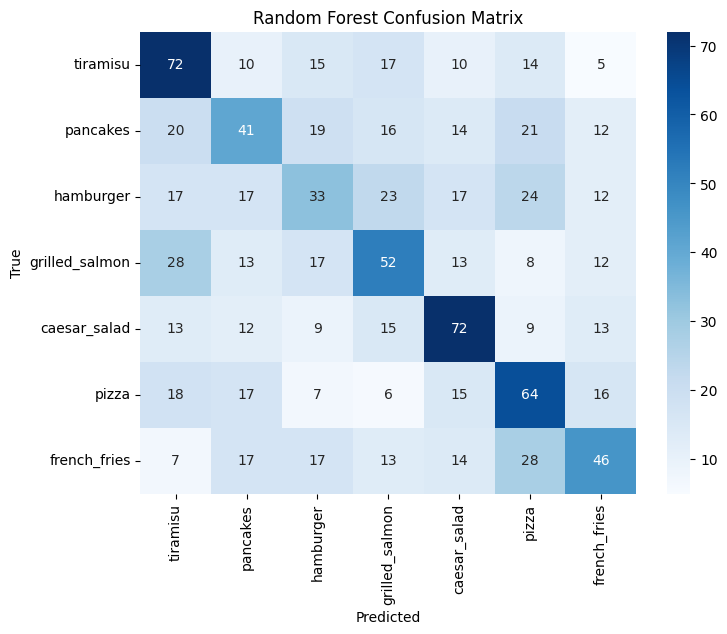

In [11]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Helper function to flatten and normalize the dataset
def preprocess_dataset(dataloader):
    X, y = [], []
    for images, labels in dataloader:
        # Normalize pixel values to [0, 1] and flatten
        images = images.numpy().reshape(images.shape[0], -1) / 255.0
        X.extend(images)
        y.extend(labels.numpy())
    return np.array(X), np.array(y)

# Preprocess train and test data
X_train, y_train = preprocess_dataset(dataloader_train)
X_test, y_test = preprocess_dataset(dataloader_test)

# Train a Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Evaluate the model
y_pred_train = rf_clf.predict(X_train)
y_pred_test = rf_clf.predict(X_test)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Classification report
print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_pred_test, target_names=list(class2name.values())))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(class2name.values()), yticklabels=list(class2name.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Random Forest Confusion Matrix')
plt.show()


Random forests give rather worse results. However they aren't that bad given how "simple" the moddel is, and how quickly it takes it to run. If we wanted to continue with the computational costs of a neural network, we would want to achieve better results than what we currently had with only the LeNet-5.

We plotted the confusion matrix to give us an easier look at how precise the classifiers were. If one category was really poorly predicted over another or not. Given how the % accuracy were low, we could have thought that some type weren't predicted at all, but it seems like the accuracy is pretty well "spread" accorss all categories.

About 35% accuracy for the random forests and 45% for the LeNet-5

# More complexe implementation, with a similar model

We start from the LeNet-5 moddel we just used

The original LeNet model also used sigmoid activation function, we prefer to use the ReLu ones. This accelerates the training.
We include batch normalisation after each convolutionl layer to normalize feature maps.(and after the activation too, it's at times places before or after activation, we make the choice to place it after).
We use nn.flatten() instead of x.view().
We also, as in the solution 2-1 fuction with blocks, this makes it a bit easier to maintain. We add some dropout to reduce the risks of overfitting.

In [12]:
class LeNet5(nn.Module):
    def __init__(self, input_channels=3, num_classes=7, activation=nn.ReLU):
        super(LeNet5, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(input_channels, 6, kernel_size=5, stride=1, padding=2),  # Padding added
            activation(),
            nn.BatchNorm2d(6),
            nn.MaxPool2d(kernel_size=2, stride=2))  # Output: (6, 17, 17)
        self.block2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=2),  # Padding added
            activation(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2))  # Output: (16, 8, 8)
        self.flatten = nn.Flatten()

        # Dynamically calculate feature map size
        example_input = torch.rand(1, input_channels, 34, 34)
        feature_map_size = self._get_flattened_size(example_input)

        self.fc = nn.Sequential(
            nn.Linear(feature_map_size, 120),
            activation(),
            nn.Dropout(0.5))
        self.fc1 = nn.Sequential(
            nn.Linear(120, 84),
            activation(),
            nn.Dropout(0.5))
        self.fc2 = nn.Linear(84, num_classes)

    def _get_flattened_size(self, x):
        x = self.block1(x)
        x = self.block2(x)
        return x.view(-1).shape[0]

    def forward(self, x):
      out = self.block1(x)
      out = self.block2(out)
      out = self.flatten(out)
      out = self.fc(out)
      out = self.fc1(out)
      out = self.fc2(out)
      return out


As we saw from the previous part, overfitting was one of the main issue. We try to tackle it now.

We apply some data augmentation and tranformation as described in the code

In [13]:
from torchvision import transforms
from PIL import Image
import numpy as np
import torch

# Normalization statistics
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

# Define transformations for training and validation datasets
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally with a probability of 0.5
    transforms.RandomRotation(15),  # Randomly rotate the image by up to 15 degrees in either direction
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        # Randomly adjust brightness, contrast, saturation, and hue of the image within specified limits:
        #   brightness: +/- 20%
        #   contrast: +/- 20%
        #   saturation: +/- 20%
        #   hue: +/- 0.1 radians (~5.73 degrees)
    transforms.RandomResizedCrop(34, scale=(0.8, 1.0)),
        # Randomly crop a region of the image, rescale it to 34x34, and ensure the cropped area is 80%-100% of the original size
    transforms.ToTensor(),  # Convert the image from a PIL.Image (or NumPy array) to a PyTorch tensor
    transforms.Normalize(mean=mean, std=std)
        # Normalize the tensor by subtracting the mean and dividing by the standard deviation for each channel (RGB)
        #   mean and std are [0.5, 0.5, 0.5] for R, G, B channels
])


val_transforms = transforms.Compose([
    transforms.Resize((34, 34)),  # Resize the image to a fixed size of 34x34 without cropping or distortion
    transforms.ToTensor(),  # Convert the image from a PIL.Image (or NumPy array) to a PyTorch tensor
    transforms.Normalize(mean=mean, std=std)
        # Normalize the tensor by subtracting the mean and dividing by the standard deviation for each channel (RGB)
        #   mean and std are [0.5, 0.5, 0.5] for R, G, B channels
])

def collate_fn_with_transform(minibatch, transform=None):
    """Transform RGB images dynamically during batching."""
    images = []
    labels = []
    for example in minibatch:
        image = example["image"]  # Access the image as a nested list
        label = example["label"]

        # Convert the nested list into a NumPy array
        image = np.array(image, dtype=np.float32)

        # Check for valid dimensions
        if len(image.shape) != 3 or image.shape[0] != 3:
            raise ValueError(f"Invalid image dimensions: {image.shape}. Expected shape (3, H, W).")

        # Permute dimensions from (C, H, W) to (H, W, C) for PIL compatibility
        image = np.transpose(image, (1, 2, 0))

        # Rescale pixel values to 0-255 for conversion to PIL.Image
        image = (image * 255).astype(np.uint8)  # Convert normalized float to 8-bit integer

        # Convert to a PIL.Image (RGB mode)
        image = Image.fromarray(image, mode="RGB")

        # Apply transformations if provided
        if transform:
            image = transform(image)

        images.append(image)
        labels.append(label)

    # Stack all transformed images and convert labels to a tensor
    return torch.stack(images), torch.tensor(labels)



We also have to update the way we define our dataloaders

In [14]:
# Training DataLoader
dataloader_train = DataLoader(
    ds_food7_split['train'],
    collate_fn=lambda x: collate_fn_with_transform(x, transform=train_transforms),
    batch_size=32,
    shuffle=True
)

# Validation DataLoader
dataloader_test = DataLoader(
    ds_food7_split['test'],
    collate_fn=lambda x: collate_fn_with_transform(x, transform=val_transforms),
    batch_size=128,
    shuffle=False
)


We then initialise the model, and make sure to run on cuda if it's available, cpu otherwise

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet5(num_classes=len(class2name)).to(device)

Next step, we define our loss function and our optimizer. We will adjust the learning rate to see what gives us the best results. We use a usual cross entropy loss for this kind of problems

In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Now creating our training function. Taking in argument the criterion (cross entropy here), our optimizer, the device and the given number of epochs we want to perform

In [17]:
def train_model(model, dataloader_train, dataloader_test, criterion, optimizer, device, epochs=10):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_train_loss = 0.0
        for images, labels in dataloader_train:
            images, labels = images.to(device).float(), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(dataloader_train)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        total_val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in dataloader_test:
                images, labels = images.to(device).float(), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = total_val_loss / len(dataloader_test)
        val_losses.append(avg_val_loss)
        val_accuracy = 100 * correct / total

        # Print progress
        print(f"Epoch [{epoch+1}/{epochs}]")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Validation Loss: {avg_val_loss:.4f}")
        print(f"  Validation Accuracy: {val_accuracy:.2f}%")

    return train_losses, val_losses


Usual Evluation function

In [18]:
def evaluate_model(model, dataloader_test, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader_test:
            images, labels = images.to(device).float(), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Final Test Accuracy: {accuracy:.2f}%")
    return accuracy


Also plotting train and validation accuracy to look for any possible overfitting. We run the code for a rather big number of epochs, it seemed to keep giving a better accuracy in the end.

Epoch [1/200]
  Train Loss: 1.8945
  Validation Loss: 1.7723
  Validation Accuracy: 32.20%
Epoch [2/200]
  Train Loss: 1.8064
  Validation Loss: 1.7385
  Validation Accuracy: 33.40%
Epoch [3/200]
  Train Loss: 1.7756
  Validation Loss: 1.6413
  Validation Accuracy: 40.40%
Epoch [4/200]
  Train Loss: 1.7471
  Validation Loss: 1.6364
  Validation Accuracy: 38.50%
Epoch [5/200]
  Train Loss: 1.7173
  Validation Loss: 1.6050
  Validation Accuracy: 41.10%
Epoch [6/200]
  Train Loss: 1.6796
  Validation Loss: 1.5750
  Validation Accuracy: 41.50%
Epoch [7/200]
  Train Loss: 1.6574
  Validation Loss: 1.5289
  Validation Accuracy: 43.60%
Epoch [8/200]
  Train Loss: 1.6384
  Validation Loss: 1.5424
  Validation Accuracy: 45.30%
Epoch [9/200]
  Train Loss: 1.6049
  Validation Loss: 1.4661
  Validation Accuracy: 49.30%
Epoch [10/200]
  Train Loss: 1.5900
  Validation Loss: 1.4505
  Validation Accuracy: 48.60%
Epoch [11/200]
  Train Loss: 1.5709
  Validation Loss: 1.4308
  Validation Accuracy: 50.8

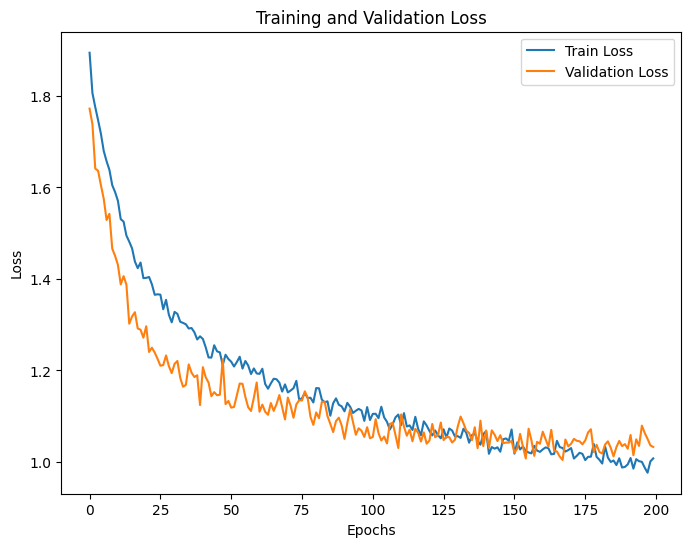

Final Test Accuracy: 65.40%


65.4

In [19]:
import matplotlib.pyplot as plt

# Train the model and get losses
train_losses, val_losses = train_model(
    model, dataloader_train, dataloader_test, criterion, optimizer, device, epochs=200
)

# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

evaluate_model(model, dataloader_test, device)

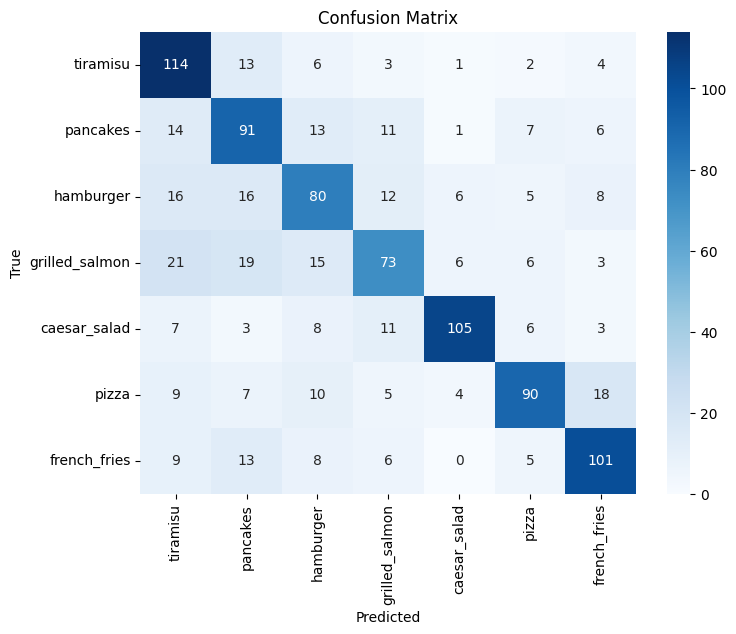

                precision    recall  f1-score   support

      tiramisu       0.60      0.80      0.68       143
      pancakes       0.56      0.64      0.60       143
     hamburger       0.57      0.56      0.57       143
grilled_salmon       0.60      0.51      0.55       143
  caesar_salad       0.85      0.73      0.79       143
         pizza       0.74      0.63      0.68       143
  french_fries       0.71      0.71      0.71       142

      accuracy                           0.65      1000
     macro avg       0.66      0.65      0.65      1000
  weighted avg       0.66      0.65      0.65      1000



In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Generate predictions
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        images, labels = images.to(device, dtype=torch.float32), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(class2name.values()), yticklabels=list(class2name.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=list(class2name.values())))

We see that with this second implementation of LeNet-5, on top of data transformation and augmentation we achieve to have much better results.
They still can look a bit underperfomring compared to what we can find in the litterature. Such as in this project https://www.kaggle.com/code/aldanaaa/high-accuracy-classification-for-food-101 , on the extended dataset with 101 food categories and having over 96% accuracy.

However, with the constraint of using a LeNet-5 architecture, our results look to be enough, and we've even been able to go through a few steps in the second part to have a stronger accuracy.

## Question 3 (Small Project)
Find a dataset that has not appeared in the course and apply any method that we have learned (or any deep learning method that you have discovered yourself).
